In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/cs287/CS287-final-project/' # for google colab. adjust accordingly

Mounted at /content/drive


In [3]:
#check gpu connection
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  2 02:22:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#check high-ram connection
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# process data, tatoeba project

In [5]:
#tatoeba dataset
#source: http://www.manythings.org/anki/
#downloaded 'fra-eng.zip' file

# #load full data
# tatoeba_df = pd.read_csv(f'{PARENT_DIR}tatoeba/fra.txt', sep='\t', header=None)
# #take a random subset
# n_sentences_total = tatoeba_df.shape[0]
# start = int((n_sentences_total/20)*19) #sample from the last chunk of data because early sentences are very short
# end = n_sentences_total
# tatoeba_df_subset = tatoeba_df.iloc[start:end, :].sample(n=2500, random_state=12345, axis='index')

# #save random subset
# tatoeba_df_subset.to_pickle(f'{PARENT_DIR}tatoeba/tatoeba_df_subset.pkl')

#load random subset
tatoeba_df_subset = pd.read_pickle(f'{PARENT_DIR}tatoeba/tatoeba_df_subset.pkl')

## source: english

english, #sentences: 2500
english, #words in shortest sentence: 6
english, #words in longest sentence: 34
english, average #words in sentence: 12.4808


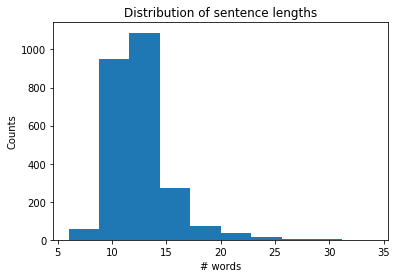

In [6]:
#source language
tatoeba_en = list(tatoeba_df_subset[0])

#examine dataset
tatoeba_en_sentence_lengths = [len(sentence.split()) for sentence in tatoeba_en]
tatoeba_len_longest_sentence = max(tatoeba_en_sentence_lengths) #used as argument when getting topk translations
print('english, #sentences:', len(tatoeba_en))
print('english, #words in shortest sentence:', min(tatoeba_en_sentence_lengths))
print('english, #words in longest sentence:', max(tatoeba_en_sentence_lengths))
print('english, average #words in sentence:', np.mean(tatoeba_en_sentence_lengths))

plt.hist(tatoeba_en_sentence_lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');

In [7]:
#add conditioning in front of each sentence
tatoeba_en = ['translate English to French: ' + sentence for sentence in tatoeba_en]
display(tatoeba_en[0:10])

['translate English to French: It is difficult to get him to do anything on the spur of the moment.',
 "translate English to French: I'd rather clean my room than spend time doing my homework.",
 'translate English to French: We desperately need more money to help fund our project.',
 'translate English to French: If you want me to help you, all you have to do is ask.',
 'translate English to French: The world was on the very brink of nuclear war during the Cuban Missile Crisis in October 1962.',
 'translate English to French: The president is expected to put forward a new energy policy.',
 'translate English to French: I planted various fruit trees on my property three years ago.',
 "translate English to French: I honestly think it's better to be a failure at something you love than to be a success at something you hate.",
 'translate English to French: If you tell a lie enough times, you begin to believe it.',
 "translate English to French: I would've told you before, but I didn't th

In [8]:
#batch dataset: create a list of lists
n_sentences = len(tatoeba_en)
batch_size = 1
n_batches = n_sentences/batch_size
tatoeba_en_batched = np.array_split(tatoeba_en, n_batches) #creates list of 100 arrays
tatoeba_en_batched = list(map(list, tatoeba_en_batched)) #now have list of 100 lists

#print head
tatoeba_en_batched[0:3]

[['translate English to French: It is difficult to get him to do anything on the spur of the moment.'],
 ["translate English to French: I'd rather clean my room than spend time doing my homework."],
 ['translate English to French: We desperately need more money to help fund our project.']]

## reference: french

french, #sentences: 2500
french, #words in shortest sentence: 6
french, #words in longest sentence: 47
french, average #words in sentence: 13.2272


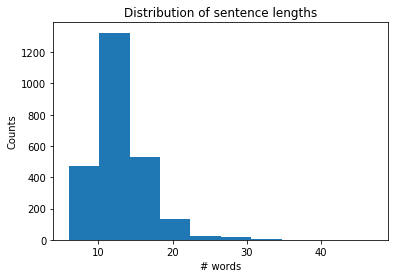

In [9]:
#reference language
tatoeba_fr = list(tatoeba_df_subset[1])

#examine dataset
tatoeba_fr_sentence_lengths = [len(sentence.split()) for sentence in tatoeba_fr]

print('french, #sentences:', len(tatoeba_fr))
print('french, #words in shortest sentence:', min(tatoeba_fr_sentence_lengths))
print('french, #words in longest sentence:', max(tatoeba_fr_sentence_lengths))
print('french, average #words in sentence:', np.mean(tatoeba_fr_sentence_lengths))

plt.hist(tatoeba_fr_sentence_lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');

# get top k translations

In [10]:
pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 80.2 MB/s 
     |████████████████████████████████| 61 kB 617 kB/s 
     |████████████████████████████████| 3.3 MB 75.6 MB/s 
     |████████████████████████████████| 895 kB 93.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
###source for code below: 
#https://huggingface.co/transformers/usage.html
#see 'Translation' section, last section at the bottom

###documentation for .generate() function
#https://huggingface.co/transformers/main_classes/model.html 
#useful arguments
# - num_beams
# - num_return_sequences
# - do_sample -- could be useful down the line
# - repetition_penalty -- could be useful down the line if we study token frequency bias
# - length_penalty -- could be useful down the line if we study length bias

In [12]:
import torch
import datetime
import gc  # Python's garbage collection interface
from tqdm import tqdm
from transformers import AutoModelWithLMHead, AutoModelForSeq2SeqLM, AutoTokenizer
import tensorflow as tf


In [13]:
###working example
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
model = model.to(device)
tokenizer = AutoTokenizer.from_pretrained('t5-base')

#inputs
source_list = ['translate English to French: Hugging Face is a technology company based in New York and Paris',
               'translate English to French: it is raining today']
inputs_tokenized = tokenizer.batch_encode_plus(source_list, return_tensors='pt', padding=True)
inputs_tokenized = inputs_tokenized.to(device)

#model
max_length = 2*tatoeba_len_longest_sentence
num_beams = 5
num_return_sequences = 1
outputs_tokenized = model.generate(**inputs_tokenized, max_length=max_length, num_beams=num_beams, num_return_sequences=num_return_sequences)

#outputs
outputs_words = tokenizer.batch_decode(outputs_tokenized, skip_special_tokens = True)
print(outputs_words)

with open(f'{PARENT_DIR}outputs_words.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(outputs_words))

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

['Hugging Face est une entreprise technologique basée à New York et à Paris.', "il pleut aujourd'hui"]


In [14]:
#function based on working example
def get_topk_translations(source_list_batched,
                          output_filename,
                          max_length,
                          num_beams=1, 
                          num_return_sequences=1, 
                          do_sample=False,
                          top_k=50,
                          top_p=1.0,
                          repetition_penalty=1.0, #future
                          length_penalty=1.0, #future
                          no_repeat_ngram_size=0 #future
                          ):
    
    print('time, start:', datetime.datetime.now())
    
    #load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
    model = model.to(device)
    tokenizer = AutoTokenizer.from_pretrained('t5-base')
    
    #get translations, one batch at a time
    output_words_all = []
    for batch in tqdm(source_list_batched):
        #inputs
        inputs_tokenized = tokenizer.batch_encode_plus(batch, return_tensors='pt', padding=True)
        inputs_tokenized = inputs_tokenized.to(device)
        #model
        outputs_tokenized = model.generate(**inputs_tokenized, 
                                           max_length=max_length, 
                                           num_beams=num_beams, 
                                           num_return_sequences=num_return_sequences,
                                           do_sample=do_sample,
                                           top_k=top_k,
                                           top_p=top_p,
                                           repetition_penalty=repetition_penalty, 
                                           length_penalty=length_penalty,
                                           no_repeat_ngram_size=no_repeat_ngram_size)
        #outputs
        outputs_words = tokenizer.batch_decode(outputs_tokenized, skip_special_tokens = True)
        output_words_all += outputs_words
        #empty cached memory
        gc.collect()
        torch.cuda.empty_cache()
    
    #write model outputs to file, store file in 'My Drive'
    with open(PARENT_DIR+'topk_translations/'+output_filename, mode='wt', encoding='utf-8') as myfile:
        myfile.write('\n'.join(output_words_all))
    print('\nmodel outputs written to file')

    print('time, end:', datetime.datetime.now())

    return output_words_all

In [15]:
#https://huggingface.co/blog/how-to-generate

## generate samples (ancestral sampling)

In [ ]:
n = 200 #n = number ancestral samples, from paper
filename = f'samples_ancestral_n{n}.txt' #output file name

#ancestral sampling
tf.random.set_seed(0)
translations_ancestral = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                               max_length=2*tatoeba_len_longest_sentence, 
                                               do_sample=True,
                                               top_k=0,
                                               num_return_sequences=n,
                                               output_filename=filename)

## generate candidates

##### beam search

### baseline

In [16]:
#n=beam_size=1 -> greedy search

for n in range(1, 11):
  print('beam size:', n)
  filename = f'baseline_beam_beam{n}_n1.txt'
  translations_beam = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                            max_length=2*tatoeba_len_longest_sentence, 
                                            num_beams=n, 
                                            num_return_sequences=1,
                                            output_filename=filename)


beam size: 1
time, start: 2021-12-02 02:23:54.730241


100%|██████████| 2500/2500 [17:11<00:00,  2.42it/s]



model outputs written to file
time, end: 2021-12-02 02:41:18.660289
beam size: 2
time, start: 2021-12-02 02:41:18.681333


100%|██████████| 2500/2500 [19:09<00:00,  2.17it/s]



model outputs written to file
time, end: 2021-12-02 03:00:39.944886
beam size: 3
time, start: 2021-12-02 03:00:39.964822


100%|██████████| 2500/2500 [19:55<00:00,  2.09it/s]



model outputs written to file
time, end: 2021-12-02 03:20:46.556450
beam size: 4
time, start: 2021-12-02 03:20:46.577108


100%|██████████| 2500/2500 [20:35<00:00,  2.02it/s]



model outputs written to file
time, end: 2021-12-02 03:41:33.192035
beam size: 5
time, start: 2021-12-02 03:41:33.211024


100%|██████████| 2500/2500 [21:13<00:00,  1.96it/s]



model outputs written to file
time, end: 2021-12-02 04:02:57.503170
beam size: 6
time, start: 2021-12-02 04:02:57.522194


100%|██████████| 2500/2500 [21:50<00:00,  1.91it/s]



model outputs written to file
time, end: 2021-12-02 04:24:59.315075
beam size: 7
time, start: 2021-12-02 04:24:59.335844


100%|██████████| 2500/2500 [22:27<00:00,  1.86it/s]



model outputs written to file
time, end: 2021-12-02 04:47:38.276646
beam size: 8
time, start: 2021-12-02 04:47:38.295694


100%|██████████| 2500/2500 [23:08<00:00,  1.80it/s]



model outputs written to file
time, end: 2021-12-02 05:10:58.496375
beam size: 9
time, start: 2021-12-02 05:10:58.515334


100%|██████████| 2500/2500 [23:44<00:00,  1.76it/s]



model outputs written to file
time, end: 2021-12-02 05:34:54.250414
beam size: 10
time, start: 2021-12-02 05:34:54.270689


100%|██████████| 2500/2500 [24:14<00:00,  1.72it/s]


model outputs written to file
time, end: 2021-12-02 05:59:19.989667


###### basic

In [ ]:
n = 5 #n = beam size, also n = number of translations per sentence
filename = f'candidates_beam_beam{n}.txt' #output file name

#beam search
translations_beam = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                          max_length=2*tatoeba_len_longest_sentence, 
                                          num_beams=n, 
                                          num_return_sequences=n,
                                          output_filename=filename)


time, start: 2021-11-20 04:11:19.683477


100%|██████████| 2500/2500 [34:24<00:00,  1.21it/s]


model outputs written to file
time, end: 2021-11-20 04:45:51.073063


###### extra (vary beam size)

In [ ]:
#n=beam_size=1 -> greedy search

for n in range(1, 11):
  print('beam size:', n)
  filename = f'candidates_beam_beam{n}.txt'
  translations_beam = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                            max_length=2*tatoeba_len_longest_sentence, 
                                            num_beams=n, 
                                            num_return_sequences=n,
                                            output_filename=filename)


beam size: 1
time, start: 2021-11-24 01:02:32.712479


100%|██████████| 2500/2500 [18:33<00:00,  2.24it/s]



model outputs written to file
time, end: 2021-11-24 01:21:13.826671
beam size: 2
time, start: 2021-11-24 01:21:13.845600


100%|██████████| 2500/2500 [20:48<00:00,  2.00it/s]



model outputs written to file
time, end: 2021-11-24 01:42:08.605538
beam size: 3
time, start: 2021-11-24 01:42:08.627192


100%|██████████| 2500/2500 [21:21<00:00,  1.95it/s]



model outputs written to file
time, end: 2021-11-24 02:03:35.984796
beam size: 4
time, start: 2021-11-24 02:03:36.004341


100%|██████████| 2500/2500 [22:16<00:00,  1.87it/s]



model outputs written to file
time, end: 2021-11-24 02:25:58.685855
beam size: 5
time, start: 2021-11-24 02:25:58.707190


100%|██████████| 2500/2500 [23:04<00:00,  1.81it/s]



model outputs written to file
time, end: 2021-11-24 02:49:09.156086
beam size: 6
time, start: 2021-11-24 02:49:09.177501


100%|██████████| 2500/2500 [23:44<00:00,  1.76it/s]



model outputs written to file
time, end: 2021-11-24 03:12:59.934132
beam size: 7
time, start: 2021-11-24 03:12:59.953926


100%|██████████| 2500/2500 [24:15<00:00,  1.72it/s]



model outputs written to file
time, end: 2021-11-24 03:37:21.328723
beam size: 8
time, start: 2021-11-24 03:37:21.349601


100%|██████████| 2500/2500 [24:56<00:00,  1.67it/s]



model outputs written to file
time, end: 2021-11-24 04:02:24.125272
beam size: 9
time, start: 2021-11-24 04:02:24.146165


100%|██████████| 2500/2500 [25:38<00:00,  1.63it/s]



model outputs written to file
time, end: 2021-11-24 04:28:08.748949
beam size: 10
time, start: 2021-11-24 04:28:08.770336


100%|██████████| 2500/2500 [26:20<00:00,  1.58it/s]


model outputs written to file
time, end: 2021-11-24 04:54:35.533189


##### ancestral sampling

In [ ]:
n = 1000 #n = number ancestral samples
filename = f'candidates_ancestral_n{n}.txt' #output file name

#ancestral sampling
tf.random.set_seed(0)
translations_ancestral = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                               max_length=2*tatoeba_len_longest_sentence, 
                                               do_sample=True,
                                               top_k=0,
                                               num_return_sequences=n,
                                               output_filename=filename)

time, start: 2021-11-20 18:31:13.188352


100%|██████████| 2500/2500 [6:58:17<00:00, 10.04s/it]



model outputs written to file
time, end: 2021-11-21 01:29:41.589014


##### top-k sampling

###### basic

In [ ]:
n=400 #n = number topk samples, chose same # as ancestral sampling
k=10 #k in top k, arbitrary
filename = f'candidates_topk_k{k}_n{n}.txt' #output file name

#top k sampling
tf.random.set_seed(0)
translations_topk = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                          max_length=2*tatoeba_len_longest_sentence, 
                                          do_sample=True,
                                          top_k=k,
                                          num_return_sequences=n,
                                          output_filename=filename)


time, start: 2021-11-20 13:31:46.769385


100%|██████████| 2500/2500 [2:40:13<00:00,  3.85s/it]



model outputs written to file
time, end: 2021-11-20 16:12:07.018743


###### extra (vary k)

In [ ]:
n=400

#already ran k=10, 20
for k in range(30, 60, 10):
  print('k:', n) #should have printed k, but no big deal
  filename = f'candidates_topk_k{k}_n{n}.txt'
  tf.random.set_seed(0)
  translations_topk = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                            max_length=2*tatoeba_len_longest_sentence, 
                                            do_sample=True,
                                            top_k=k,
                                            num_return_sequences=n,
                                            output_filename=filename)


k: 400
time, start: 2021-11-21 15:53:39.385414


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

100%|██████████| 2500/2500 [3:07:25<00:00,  4.50s/it]



model outputs written to file
time, end: 2021-11-21 19:01:52.141942
k: 400
time, start: 2021-11-21 19:01:52.162867


100%|██████████| 2500/2500 [3:11:03<00:00,  4.59s/it]



model outputs written to file
time, end: 2021-11-21 22:13:03.080660
k: 400
time, start: 2021-11-21 22:13:03.105241


100%|██████████| 2500/2500 [3:13:39<00:00,  4.65s/it]



model outputs written to file
time, end: 2021-11-22 01:26:49.781677


In [ ]:
n=400

#already ran k=10, 20, ..., 80
for k in range(90, 110, 10):
  print('k:', k) #should have printed k, but no big deal
  filename = f'candidates_topk_k{k}_n{n}.txt'
  tf.random.set_seed(0)
  translations_topk = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                            max_length=2*tatoeba_len_longest_sentence, 
                                            do_sample=True,
                                            top_k=k,
                                            num_return_sequences=n,
                                            output_filename=filename)


k: 90
time, start: 2021-11-24 21:26:09.303641


100%|██████████| 2500/2500 [3:11:09<00:00,  4.59s/it]



model outputs written to file
time, end: 2021-11-25 00:37:31.754446
k: 100
time, start: 2021-11-25 00:37:31.774959


100%|██████████| 2500/2500 [3:12:43<00:00,  4.63s/it]



model outputs written to file
time, end: 2021-11-25 03:50:27.284947


##### top p (nucleus) sampling

###### basic

In [ ]:
n = 400 #n = number of samples, from paper
p = 0.7 #p in top-p sampling, from paper
filename = f'candidates_topp_p{int(p*100)}_n{n}.txt'

###top p (nucleus) sampling
tf.random.set_seed(0)
translations_topp = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                          max_length=2*tatoeba_len_longest_sentence, 
                                          do_sample=True,
                                          top_k=0,
                                          top_p=p,
                                          num_return_sequences=n,
                                          output_filename=filename)

time, start: 2021-11-20 16:12:07.049265


100%|██████████| 2500/2500 [1:29:56<00:00,  2.16s/it]



model outputs written to file
time, end: 2021-11-20 17:42:10.154429


###### extra (vary p)

In [ ]:
n=400

#when p=1.0, does that equal ancestral sampling?

for p in [x / 10.0 for x in range(1, 11)]:
  print('p:', p)
  filename = f'candidates_topp_p{int(p*100)}_n{n}.txt'
  tf.random.set_seed(0)
  translations_topp = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                            max_length=2*tatoeba_len_longest_sentence, 
                                            do_sample=True,
                                            top_k=0,
                                            top_p=p,
                                            num_return_sequences=n,
                                            output_filename=filename)


p: 0.1
time, start: 2021-11-22 01:26:49.828226


100%|██████████| 2500/2500 [1:01:10<00:00,  1.47s/it]



model outputs written to file
time, end: 2021-11-22 02:28:07.857969
p: 0.2
time, start: 2021-11-22 02:28:07.885422


100%|██████████| 2500/2500 [1:03:22<00:00,  1.52s/it]



model outputs written to file
time, end: 2021-11-22 03:31:38.000569
p: 0.3
time, start: 2021-11-22 03:31:38.031138


100%|██████████| 2500/2500 [1:05:54<00:00,  1.58s/it]



model outputs written to file
time, end: 2021-11-22 04:37:39.987916
p: 0.4
time, start: 2021-11-22 04:37:40.016151


100%|██████████| 2500/2500 [1:10:21<00:00,  1.69s/it]



model outputs written to file
time, end: 2021-11-22 05:48:08.721417
p: 0.5
time, start: 2021-11-22 05:48:08.751122


100%|██████████| 2500/2500 [1:17:02<00:00,  1.85s/it]



model outputs written to file
time, end: 2021-11-22 07:05:18.699905
p: 0.6
time, start: 2021-11-22 07:05:18.773142


100%|██████████| 2500/2500 [1:24:29<00:00,  2.03s/it]



model outputs written to file
time, end: 2021-11-22 08:29:55.887776
p: 0.7
time, start: 2021-11-22 08:29:55.915840


100%|██████████| 2500/2500 [1:34:28<00:00,  2.27s/it]



model outputs written to file
time, end: 2021-11-22 10:04:31.457363
p: 0.8
time, start: 2021-11-22 10:04:31.481369


100%|██████████| 2500/2500 [1:50:27<00:00,  2.65s/it]



model outputs written to file
time, end: 2021-11-22 11:55:06.244709
p: 0.9
time, start: 2021-11-22 11:55:06.269534


  1%|          | 13/2500 [00:46<2:32:45,  3.69s/it]

In [ ]:
n=400

#when p=1.0, does that equal ancestral sampling?

for p in [x / 10.0 for x in range(9, 11)]:
  print('p:', p)
  filename = f'candidates_topp_p{int(p*100)}_n{n}.txt'
  tf.random.set_seed(0)
  translations_topp = get_topk_translations(source_list_batched=tatoeba_en_batched, 
                                            max_length=2*tatoeba_len_longest_sentence, 
                                            do_sample=True,
                                            top_k=0,
                                            top_p=p,
                                            num_return_sequences=n,
                                            output_filename=filename)


p: 0.9
time, start: 2021-11-24 04:54:36.245170


100%|██████████| 2500/2500 [2:12:52<00:00,  3.19s/it]



model outputs written to file
time, end: 2021-11-24 07:07:35.163100
p: 1.0
time, start: 2021-11-24 07:07:35.186182


100%|██████████| 2500/2500 [3:08:41<00:00,  4.53s/it]



model outputs written to file
time, end: 2021-11-24 10:16:23.433286


# MBR decoding

In [ ]:
!pip install gpytorch

     |████████████████████████████████| 503 kB 5.3 MB/s 


In [ ]:
!git clone https://github.com/Roxot/mbr-nmt.git
%cd mbr-nmt
!pip install .

Cloning into 'mbr-nmt'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 313 (delta 1), reused 1 (delta 0), pack-reused 306
Receiving objects: 100% (313/313), 206.35 MiB | 38.20 MiB/s, done.
Resolving deltas: 100% (186/186), done.
/content/mbr-nmt
Processing /content/mbr-nmt
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 78 kB 3.7 MB/s 
  Created wheel for mbr-nmt: filename=mbr_nmt-0.1.dev0-py3-none-any.whl size=24919 sha256=4d2a8ae0b56d77b97bf334b72434e42bd72925e0922f804f26724d9a06c1542e
  Stored in directo

In [ ]:
#!mbr-nmt translate -s test/data/samples-2.en -n 2 -u bleu -o outMBR.txt

# need to add ability to include samples vs candidates
# TODO: Format candidate files with "NC = <number of candidates>" before each set of candidates
def mbr_from_sample(sample_output_filename, candidate_output_filename, final_output_filename):
  !mbr-nmt translate -s /content/drive/MyDrive/CS287-final-project/topk_translations/$sample_output_filename -n 5 -u bleu -o outMBR.txt #-c /content/drive/MyDrive/CS287-final-project/topk_translations/$candidate_output_filename
  !mbr-nmt convert -f mbr-nmt -i outMBR.txt -o /content/drive/MyDrive/CS287-final-project/MBR/$final_output_filename

In [ ]:
mbr_from_sample('tatoeba_enfr_ancestral_top5.txt', 'tatoeba_enfr_beam_beam5_top5.txt', 'tatoeba_enfr_ancestral_mbr.txt')

Namespace(add_eos=False, bleurt_checkpoint=None, bmc=False, c2f=False, candidates=None, command='translate', kernel_utility=None, lang='en', num_samples=5, output_file='outMBR.txt', samples='/content/drive/MyDrive/CS287-final-project/topk_translations/tatoeba_enfr_ancestral_top5.txt', seed=None, store_expected_utility=None, subsample_per_candidate=False, subsample_size=None, subsample_size_2=None, threads=-1, top_k=None, utility='bleu', utility_2=None)
Starting 2 parallel processes.
Started process 1 for doing 1250 translations.
Started process 2 for doing 1250 translations.
Decoding took 22s


In [ ]:
%pwd

'/content/mbr-nmt'

## calculate BLEU scores

In [ ]:
from torchtext.data.metrics import bleu_score

In [ ]:
def calc_bleu_score(translations, references):
    translations_formatted = [translation.split() for translation in translations]
    references_formatted = [[translation.split()] for translation in references]
    return bleu_score(translations_formatted, references_formatted)

In [ ]:

print('greedy:', calc_bleu_score(translations=tatoeba_enfr_greedy, references=tatoeba_fr))
print('beam, beam5, top1:', calc_bleu_score(translations=tatoeba_enfr_beam_beam5_top1, references=tatoeba_fr))
print('top-k sampling, k=20, top1:', calc_bleu_score(translations=tatoeba_enfr_topk_k20_top1, references=tatoeba_fr))
print('top-k sampling, k=50, top1:', calc_bleu_score(translations=tatoeba_enfr_topk_k50_top1, references=tatoeba_fr))
print('ancestral sampling, top1:', calc_bleu_score(translations=tatoeba_enfr_ancestral_top1, references=tatoeba_fr))
print('nucleus sampling, p=0.50, top1:', calc_bleu_score(translations=tatoeba_enfr_nucleus_p50_top1, references=tatoeba_fr))
print('nucleus sampling, p=0.90, top1:', calc_bleu_score(translations=tatoeba_enfr_nucleus_p90_top1, references=tatoeba_fr))


greedy: 0.37735436171414116
beam, beam5, top1: 0.39751948518368896
top-k sampling, k=20, top1: 0.2056148797273636
top-k sampling, k=50, top1: 0.19476744532585144
ancestral sampling, top1: 0.17997339367866516
nucleus sampling, p=0.50, top1: 0.36389776091588677
nucleus sampling, p=0.90, top1: 0.2452133744955063


In [ ]:
with open('/content/drive/MyDrive/CS287-final-project/MBR/tatoeba_enfr_beam_beam5_mbr.txt') as file:
    tatoeba_enfr_beam_beam5_mbr = file.readlines()
    print('beam, beam5, mbr:', calc_bleu_score(translations=tatoeba_enfr_beam_beam5_mbr, references=tatoeba_fr))


beam, beam5, mbr: 0.24878725409507751
